# Generation of speckle pattern using Zemax's Grid sag surface

### References

1. Statistical properties of Laser Speckle, J. Goodman
2. Laser Doppler and time-varying speckle: a reconciliation, J. David Briers

In [1]:
from __future__ import division, print_function
import os as os
import collections as co
import numpy as np
import math as math
import scipy.stats as sps
import scipy.optimize as opt
import matplotlib.pyplot as plt
from IPython.display import Image as ipImage
import pyzdde.zdde as pyz
import pyzdde.zfileutils as zfu
# The following python modules are available at
# 1. https://github.com/indranilsinharoy/iutils/blob/master/optics/fourier.py
# 2. https://github.com/indranilsinharoy/iutils/blob/master/optics/beam.py
import iutils.optics.fourier as fou
import iutils.optics.beam as bou

%matplotlib inline

In [2]:
zmxfile = 'SpeckleUsingPOP_GridSagSurf.zmx'
lensPath = os.path.join(os.getcwd().split('Examples')[0], 'ZMXFILES')
lensFile = os.path.join(lensPath, zmxfile)

In [3]:
ln = pyz.createLink()
ln.zLoadFile(lensFile)

0

In [4]:
# Surfaces in the LDE @ Zemax.
ln.ipzGetLDE()

SURFACE DATA SUMMARY:

Surf     Type         Radius      Thickness                Glass      Diameter          Conic   Comment
 OBJ STANDARD       Infinity       Infinity                                  0              0
 STO STANDARD       Infinity            2.5                                  5              0 Waist
   2 STANDARD       Infinity            1.5                N-BK7            10              0 diffuser smooth
   3 GRID_SAG       Infinity           1000                                 10              0 diffuser back
 IMA STANDARD       Infinity                                                 5              0 near field


In [5]:
# Define surface number constants to remember
SURF_BEAMSTART = 1
SURF_DIFFSMOOTHFACE = 2 # Smooth face of the diffuser
SURF_GRIDSAG = 3   # Rough face of the diffuser
SURF_IMA = 4

In [6]:
# Get wavelength (Zemax returns in units of microns)
wavelength = ln.zGetWave(ln.zGetPrimaryWave()).wavelength/1000.0
print(u'Wavelength, \u03BB = {:.3e} mm'.format(wavelength))

Wavelength, λ = 5.320e-04 mm


In [7]:
# Set sigma, sampling, and semi-diameter of the grid sag surface
# the semi-diameter must match that of the grid sag surface in LDE
#sigma = 5*wavelength # set sigma later 
nx, ny = 401, 401
semidia = 5.0

In [8]:
# Start out with a zero height profile surface
comment = 'zero height profile sag'
filename = os.path.join(os.path.expandvars("%userprofile%"), 'Documents', 
                        'Zemax\\Objects\\Grid Files', 'gridsag_zeroheight.DAT')

# the function randomGridSagFile() in pyzdde/zfileutils generates grid sag ASCII 
# file with Gaussian distributed sag profile
z, sagfile = zfu.randomGridSagFile(mu=0, sigma=np.inf, semidia=semidia, nx=nx, 
                                    ny=ny, fname=filename, comment=comment)

# load the zero height grid sag surface file in to the extra data editor
ln.zImportExtraData(surfNum=SURF_GRIDSAG, fileName=sagfile)

0

##### Set up POP analysis

In [9]:
# Function to set the POP analysis parameters
def set_POP(ln, data='irr', wide=50.0, waist=1.0, start=1, end=None):
    """helper function to set POP
    
    Parameters
    ----------
    ln : object
    data : string
        the display data type. 'irr' or 'phase'
    wide : float
        initial width and height of the region to display. See Note 2.
    waist : float
        beam radius at the waist (in mm)
    start : integer
        start surface
    end : integer
        end surface
    
    Return
    ------
    settinsfilename : string
        CFG settings file name 
    
    Note
    ----
    1. Use the same name for the CFG settings file. This helps POPD to return the correct
       values of parameters (mostly)
    2. The ``auto`` parameter in the function ``zSetPOPSettings()`` does not seem to work
       as expected. Hence, we need to provide the ``widex`` and ``widey`` parameters 
       explicitly. In order to get the appropriate values for these parameters, use the 
       "Automatic" button in Zemax POP analysis window for the particular design file 
    """
    setfile = ln.zGetFile().lower().replace('.zmx', '.CFG')
    datatype = 1 if data == 'phase' else 0 
    GAUSS_WAIST, WAIST_X, WAIST_Y = 0, 1, 2
    S_1024, S_2048 = 6, 7 

    cfgfile = ln.zSetPOPSettings(data=datatype, settingsFile=setfile, 
                                 startSurf=start, endSurf=end, field=1, wave=1, 
                                 beamType=GAUSS_WAIST, 
                                 paramN=((WAIST_X, WAIST_Y), (waist, waist)), 
                                 sampx=S_2048, sampy=S_2048, widex=wide, widey=wide)
    return cfgfile

In [10]:
# Helper functions to display POP display data
def plot_pop_display_data(popdata, height, width, title):
    """plot pop display data retrieved from Zemax application
    using `zGetPOP()` function
    
    Parameters
    ----------
    popdata : list 
        list of speckle patterns or pop display data arrays
    height : list
        list of height of the speckle patterns
    width : list 
        list of width of the speckle patterns
        
    Returns
    -------
    None
    
    Notes
    -----
    The labels of the plot extents are not guaranteed to be exact
    """ 
    numPatts = len(popdata)
    figHeight = 5
    figWidth = 1.3*figHeight*numPatts if numPatts > 1 else figHeight
    fig = plt.figure(figsize=(figWidth, figHeight))
    for i, (pat, h, w, t) in enumerate(zip(popdata, height, width, title), 1):
        ax = fig.add_subplot(1, numPatts, i)
        ax.imshow(pat, cmap=plt.cm.plasma, extent=(-w/2, w/2, h/2, -h/2))
        ax.set_xlabel('mm'); ax.set_ylabel('mm')
        ax.set_title(t, y=1.02)
    fig.tight_layout()
    plt.show()

In [11]:
# helper function to zoom 
def zoom(img, amount=2):
    """simple function for cropping the image data for display
    
    Parameters
    ----------
    img : ndarray
        2-dim ndarray
    amount : float
        amount of zooming
    """
    r, c = img.shape
    newR = r//amount
    newC = c//amount
    startR, startC = (r - newR)//2, (c - newC)//2
    return img[startR:startR+newR, startC:startC+newC]

In [12]:
# the `wide` value was determined from the Zemax main applicaiton's POP analysis
# setting by clicking on "Automatic"
beamRadius = 1.0   
cfgfile = set_POP(ln, data='irr', wide=80.0, waist=beamRadius, start=SURF_BEAMSTART, end=SURF_IMA)
cfgfile

'c:\\programsandexperiments\\python\\optics\\pyzdde\\zmxfiles\\speckleusingpop_gridsagsurf.CFG'

##### Rayleigh range and Fraunhofer distances

In [13]:
def rayleigh_fraunhofer(beamRadius, wavelength):
    """print the rayleigh range and Fraunhofer distance in mm
    """
    beamDia = 2.0*beamRadius
    rr = bou.GaussianBeam(waistDiameter=beamDia, wavelength=wavelength).rayleigh
    fd = fou.fraunhofer_distance(d=beamDia,  wavelen=wavelength)
    print('Rayleigh range = {:2.2f} mm'.format(rr))
    print('Fraunhofer distance (far-field) = {:2.2f} mm'.format(fd))
    

In [14]:
rayleigh_fraunhofer(beamRadius, wavelength)

Rayleigh range = 5905.25 mm
Fraunhofer distance (far-field) = 15037.59 mm


In [15]:
# view the set parameters for POP analysis. Note that this analysis takes little more than a min
# because of large number of samples
popinfo, irrdata = ln.zGetPOP(settingsFile=cfgfile, displayData=True, timeout=3*60)
popinfo

POPinfo(surf=4, peakIrr=0.97193, totPow=1.5708, fibEffSys=None, fibEffRec=None, coupling=None, pilotSize=1.01434, pilotWaist=1.0, pos=1003.49, rayleigh=5905.25, gridX=2048, gridY=2048, widthX=80.001024, widthY=80.001024)

C:\Anaconda2\lib\site-packages\ipykernel\__main__.py:16: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


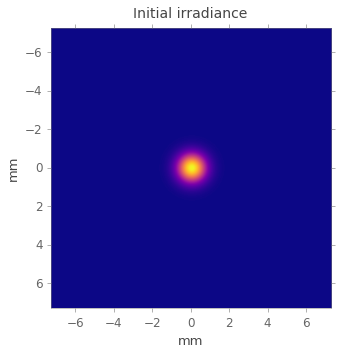

In [16]:
mmPerPxY, mmPerPxX = popinfo.widthY/popinfo.gridY, popinfo.widthX/popinfo.gridX
irradiance = zoom(np.array(irrdata), amount=5.5)
pxY, pxX = irradiance.shape
h, w = mmPerPxY*pxY, mmPerPxX*pxX
plot_pop_display_data([irradiance,], [h,], [w,], ['Initial irradiance',])

##### Create and import rough sag surface into Zemax

In [17]:
# Helper function to see the surface statistics
def sag_statistics(sag, sigma=1, wave=1, nbins=100):
    """dispaly basic statistics of the sag profile
    
    """
    h, w = sag.shape
    absMax, meanSag = np.max(np.abs(sag)), np.mean(sag)
    varSag, stdSag = np.var(sag), np.std(sag)
    print(u'sag absolute max: {:.4f} mm ({:.4f}\u03BB)'
          .format(absMax, absMax/wave))
    print(u'sag mean value: {:.4e} mm ({:.4f}\u03BB)'
          .format(meanSag, meanSag/wave))
    print(u'sag std deviation: {:.4e} ({:.4f}\u03BB)'
          .format(stdSag, stdSag/wave))
    hist, binEdges = np.histogram(sag, bins=nbins, 
                                  range=(-5*sigma, 5*sigma), density=True)
    binCenters = (binEdges[:-1] + binEdges[1:])/2
    #
    def gauss(x, mu, sigma):
        """gaussian distribution
        """
        a = 1.0/(sigma*np.sqrt(2.0*np.pi))
        return a*np.exp(-(x - mu)**2/(2.0*sigma**2))
    
    # figures
    fig = plt.figure(figsize=(8, 4))
    ax0 = fig.add_axes([0.00, 0.00, 0.40, 0.95])   
    ax1 = fig.add_axes([0.49, 0.00, 0.46, 1.00])
    ax2 = fig.add_axes([0.98, 0.05, 0.02, 0.89])
    gaussDist = gauss(binCenters, mu=0, sigma=sigma)
    ax0.plot(binCenters/wave, gaussDist, lw=6, alpha=0.4,
            label='Gaussian dist')
    ax0.plot(binCenters/wave, hist, label='Fluctuation hist')
    ax0.set_xlim(-5*sigma/wave, 5*sigma/wave)
    ax0.yaxis.set_ticks([])
    ax0.legend(fontsize=8)
    ax0.set_xlabel(r'$\lambda$', fontsize=15)
    ax0.set_title('Sag fluctuation histogram', y=1.01)
    im = ax1.imshow(sag, cmap=plt.cm.jet, vmin=-absMax, vmax=absMax,
                    interpolation='none')
    ax1.set_title('Sag surface profile', y=1.01)
    plt.colorbar(im, ax2)
    plt.show()

Diffuser semi-diameter = 5.000 mm
Nx = 401, Ny = 401
delx = 0.02500 mm
dely = 0.02500 mm
sag absolute max: 0.0126 mm (23.6179λ)
sag mean value: 9.8842e-07 mm (0.0019λ)
sag std deviation: 2.6622e-03 (5.0040λ)


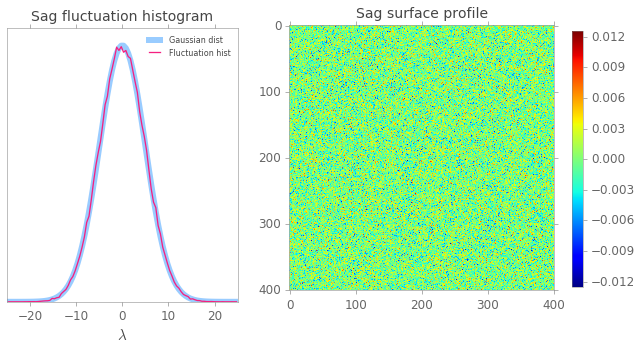

In [18]:
# Create a rough surface and display the surface roughness statistics
sigma = 5.0*wavelength  # surface roughness
comment = 'gauss random dist of grid sag for speckle generation'
print('Diffuser semi-diameter = {:2.3f} mm'.format(semidia))
print('Nx = {:d}, Ny = {:d}'.format(nx, ny))
print('delx = {:.5f} mm'
      .format(2.0*semidia/(nx-1)))
print('dely = {:.5f} mm'
      .format(2.0*semidia/(ny-1))) 

z, sagfile = zfu.randomGridSagFile(mu=0, sigma=sigma, semidia=semidia, nx=nx, ny=ny)
sag_statistics(z.reshape(ny, nx), sigma, wavelength)

In [19]:
# load the Grid sag surface file in to the extra data editor
ln.zImportExtraData(surfNum=SURF_GRIDSAG, fileName=sagfile)

0

### Retrieve and plot the speckle data generated in Zemax

In [20]:
popinfo, irrdata = ln.zGetPOP(settingsFile=cfgfile, displayData=True, timeout=3*60)
popinfo

POPinfo(surf=4, peakIrr=0.083308, totPow=1.3497, fibEffSys=None, fibEffRec=None, coupling=None, pilotSize=1004.38, pilotWaist=0.000169545, pos=1005.59, rayleigh=0.000169749, gridX=2048, gridY=2048, widthX=80.048128, widthY=80.021504)

NOTE: If the Zemax Error Message "*The reference rays cannot be traced or are too close together*", please check the maximum aboslute height of the grid sag surface. It is probably much larger (more than an order of magnitude) than the wavelength of the source.

C:\Anaconda2\lib\site-packages\ipykernel\__main__.py:16: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


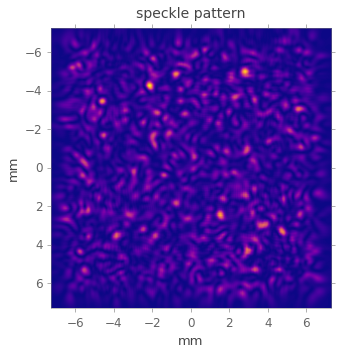

In [21]:
mmPerPxY, mmPerPxX = popinfo.widthY/popinfo.gridY, popinfo.widthX/popinfo.gridX
speckle = zoom(np.array(irrdata), amount=5.5)
pxY, pxX = irradiance.shape
h, w = mmPerPxY*pxY, mmPerPxX*pxX
plot_pop_display_data([speckle,], [h,], [w,], ['speckle pattern',])

### First order speckle statistics

**Distribution of speckle intensity**

The speckle intensity of the ideal Gaussian speckle pattern follows a negative exponential probability-density function [1]. The (negative) exponential probability density function is given as:

$$
P(x | \lambda) = \left \{ \begin{array}{cc} 
\lambda e^{-\lambda x} & \hspace{4pt} & x \geq 0, \\
0 & \hspace{4pt} & x < 0,   
\end{array}\right .\       
$$



Rate parameter, λ = 158.707


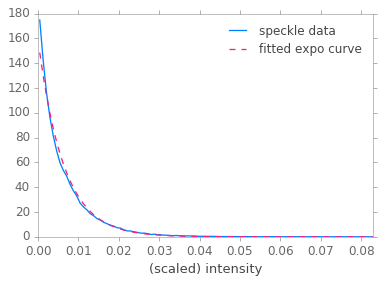

In [22]:
# histogram of speckle
numBins = 100
hist, binEdges = np.histogram(speckle.flatten(), bins=numBins, density=True)
binCenters = (binEdges[:-1] + binEdges[1:])/2
fig, ax = plt.subplots(1, 1)
ax.plot(binCenters, hist, label='speckle data')
# fit an exponential curve. Since the data is noise-free, we will use
# the method provided by Scipy
loc, scale = sps.expon.fit(speckle.flatten(), floc=0)
y = sps.expon.pdf(binCenters, loc=loc, scale=scale)
ax.plot(binCenters, y, linestyle='dashed', label='fitted expo curve')
ax.set_xlim(0, np.max(binCenters))
ax.legend(fontsize=12)
ax.set_xlabel('(scaled) intensity')
print(u'Rate parameter, \u03BB = {:.3f}'.format(1.0/scale))
plt.show()

#### Speckle contrast

For ideal Gaussian speckle pattern, the standard deviation, $\sigma$ of the intensity is equal to the mean intensity, $\langle I \rangle$, where strictly, $\langle \, \rangle$ stands for ensemble average. Here, we will assume that the ensemble average equals the sample average. 

In [23]:
speckleContrast = np.std(speckle.flatten())/ np.mean(speckle.flatten())
print('Speckle contrast = {:2.5f}'.format(speckleContrast))

Speckle contrast = 1.09703


### Second order speckle statistics

The width of the autocorrelation of the intensity of the speckle distribution gives a reasonable measure of the "average" width of a speckle in the pattern [1]. 

In [24]:
# Expected speckle size

def set_small_values_to_zero(tol, *values):
    """helper function to set infinitesimally small values to zero
    
    Parameters
    ----------
    tol : float
        threshold. All numerical values below abs(tol) is set to zero
    *values : unflattened sequence of values
        
    Returns
    -------

    """
    return [0.0 if abs(value) < tol else value for value in values]

#TODO!! Move this function to PyZDDE!! (could rename to specify it's a POP analysis helper function)
def get_beam_centroid_radius(ln, surf, update=True):
    """returns the beam width and position at surface ``surf`` using
    POP analysis
    
    Parameters
    ----------
    surf : integer
        surface number. 0 implies last surface
    udpate : bool
        if `True`, then Zemx will recompute all pupil positions and solves, etc
        and the data in the LDE will be updated before retrieving the POPD
        values.
    
    Returns
    -------
    para : namedtuple
        beam parameters (cx, cy, rx, ry) where cx, cy are the coordinates
        of the centroid of the beam w.r.t. the chief ray
    """
    CENTROID_X, CENTROID_Y, BEAM_RADIUS_X, BEAM_RADIUS_Y = 21, 22, 23, 24
    wave, field, xtr1, xtr2 = 0, 0, 0, 0
    if update:
        ln.zGetUpdate()
    cx = ln.zOperandValue('POPD', surf, wave, field, CENTROID_X, xtr1, xtr2)
    cy = ln.zOperandValue('POPD', surf, wave, field, CENTROID_Y, xtr1, xtr2)
    rx = ln.zOperandValue('POPD', surf, wave, field, BEAM_RADIUS_X, xtr1, xtr2)
    ry = ln.zOperandValue('POPD', surf, wave, field, BEAM_RADIUS_Y, xtr1, xtr2)
    cx, cy, rx, ry = set_small_values_to_zero(1e-12, cx, cy, rx, ry)
    beam = co.namedtuple('beam', ['cx', 'cy', 'rx', 'ry'])
    return beam(cx, cy, rx, ry)

In [25]:
beamDiameterAtDiff = 2.0*get_beam_centroid_radius(ln, SURF_DIFFSMOOTHFACE).rx
THICKNESS = 3
diffScDist = ln.zGetSurfaceData(surfNum=SURF_IMA - 1, code=THICKNESS)  # note this is not general
theorySpeckleWidth = wavelength*diffScDist/beamDiameterAtDiff
print('Beam diameter @ diffuser = {} mm'.format(beamDiameterAtDiff))
print('Distance between diffuser and obs. screen = {} mm'.format(diffScDist))
print(u'Theoretical speckle width = {:.5f} mm ({:.3E} \u03BCm)'
      .format(theorySpeckleWidth, theorySpeckleWidth/wavelength))

Beam diameter @ diffuser = 2.00000018 mm
Distance between diffuser and obs. screen = 1000.0 mm
Theoretical speckle width = 0.26600 mm (5.000E+02 μm)


After fitting a Gaussian distribution the $\text{FWHM}$ and $1/e^2$ widths may be estimated as follows:

If $F(x)$ is the Gaussian curve, and $F(x) \Big|_{x=x^+} = \frac{1}{2}$  and $F(x) \Big|_{x=x^-} = \frac{1}{2}$ on either side of the mean, then the $\text{FWHM}$ width is given by $x^+ - x^-$. Similarly, the $1/e^2$ width may be estimated by taking the difference between the abscissae where $F(x)=1/e^2=0.135335$


$$
\begin{array}{cl}
F_x & = & a e^{- \frac{(x - \mu)^2}{2\sigma^2} } \\\
ln(F_x) & = & ln(a) - \frac{(x - \mu)^2}{2\sigma^2} \\\
\frac{(x - \mu)^2}{2\sigma^2} & = & ln \left( \frac{a}{F_x} \right)\\\
x & = & \mu + \sigma \sqrt{ \left[ 2 \, ln \left( \frac{a}{F_x} \right) \right]}
\end{array}
$$

If we represent

$$
x^{\pm} = \mu \pm \sigma \sqrt{ \left[ 2 \, ln \left( \frac{a}{F_x} \right) \right]}
$$


then,

$$
\Delta x = 2 \, \sigma \sqrt{ \left[ 2 \, ln \left( \frac{a}{F_x} \right) \right]}
$$

In [26]:
# Helper functions for estimating the speckle size
# Most of the ideas for determining the speckle size is from
# "Speckle Size via Autocorrelation", by Joel 
# mathworks.com/matlabcentral/fileexchange/
# 25046-speckle-size-via-autocorrelation/content//SpeckleSize.m

def xcov(x, y=None, scale='none'):
    """returns the cross-covariance of two discrete-time
    sequences, `x` and `y`. 
    
    Parameters
    ----------
    x : ndarray
        1-dim ndarray
    y : ndarray, optional
        1-dim ndarray. If y is 'None', the autocovariance of
        the sequence `x`is returned
    scale : string, optional
        specifies a normalization option for the cross-
        covariance
    
    Returns
    -------
    crosscov : ndarray
        1-dim ndarray of the cross-covariance sequence. Length
        of `crosscov` is `2*m - 1`, where `m` is the length of
        `x` (and `y` is passed)
        
    Notes
    -----
    `xcov` emulates Matlab's `xcov()` function in a 
    limited way. For details see _[1]
    
    References
    ----------
    .. [1] http://www.mathworks.com/help/signal/ref/xcov.html
    """
    m = len(x)
    y = x if y is None else y
    assert m == len(y), \
    'Sequences x and y must be of same length.'
    raw = np.correlate(x - np.mean(x), 
                        y - np.mean(y), 'full')
    if scale == 'coeff':
        crosscov = raw/np.max(raw)
    elif scale == 'biased':
        crosscov = raw/m
    elif scale == 'unbiased':
        maxlag = m - 1
        k = np.arange(-maxlag, maxlag + 1)
        crosscov = raw/(m - np.abs(k))
    else:
        crosscov = raw
    return crosscov

def avg_autocov(x, axis=0, scale='coeff'):
    """returns the "average" autocovariance of x along
    the `axis` specified
    
    Parameters
    ----------
    x : ndarray
        2-dim ndarray
    axis : integer
        0 = average auto-covariance along the first dimension; 
        1 = average auto-covariance along the second dimension
    scale : string, optional
        specifies a normalization option for the cross-
        covariance
        
    Returns
    -------
    aCorr : ndarray
        1-dim ndarray of average auto-covariance along the
        `axis`, normalized such that the maximum is 1.
    """
    x = x if axis else x.T
    r, c = x.shape
    avgAcov = np.zeros(2*c - 1)
    for row in x:
        avgAcov = avgAcov + xcov(row, scale=scale)
    return avgAcov/np.max(avgAcov)

def gauss(x, a, mu, sigma):
    """gaussian model function for curve fitting 
    """
    return a*np.exp((-(x - mu)**2)/(2.0*sigma**2))

def gauss_fit(data, expectedSize=10):
    """helper function for curve gaussian curve fitting
    
    Parameters
    ----------
    data : ndarray
        1-dim ndarray consisting of the data
    expectedSize : ndarray
        expected size of the speckle???? (in pixels)
    
    Returns
    -------
    a : float
        
    mu : float
        mean of the gaussian curve
    sigma : float
        standard deviation of the gaussian curve
    
    TO DO!!!
    What is a good `expectedSize`? 
    probably should use some standard deviation of speckle estimate, 
    and pixel size ... based on the beam width and wavelength
    """
    # clean the data by simple thresholding
    y = data.copy()
    upper, lower = 1.0, 0.005
    y[y > upper] = 1.0
    y[y < lower] = 0.0
    m = len(y)
    x = np.arange(0, m) # index 
    p0 = [1.0, m/2, expectedSize] # initial guess
    pEst, pCov = opt.curve_fit(gauss, x, y, p0=p0)
    stdErr = np.sqrt(np.diag(pCov))
    return pEst[0], pEst[1], pEst[2], stdErr

def width_FWHM(a, sigma):
    return 2.0*sigma*np.sqrt(2.0*np.log(a/0.5))

def width_oneOESqu(a, sigma):
    return 2.0*sigma*np.sqrt(2.0*np.log(a/.1353353))

def plot_avg_intensity_autocovariance(x, acR, acRFit, acC, acCFit):
    """helper function to plot the average intensity autocovariances
    and the fit curves for visual inspection
    
    Parameters
    ----------
    x : ndarray
        indices
    acR, acC : ndarray
        1-dim ndarray of the average autocovariance along the rows/columns
    acRFit, acRFit : ndarray
        1-dim ndarray of the fitted gaussian curve along the rows/columns
    
    """
    fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(12, 7))
    ax0.plot(x, acR, label='avg acov horizontal')
    ax0.plot(x, acRFit, '--', label='fitted gauss')
    ax0.legend()
    ax0.autoscale(tight=True)
    ax1.plot(x, acC, label='avg acov vertical')
    ax1.plot(x, acCFit, '--', label='fitted gauss')
    ax1.legend()
    ax1.autoscale(tight=True)
    plt.show()
    
def estimate_mean_speckle_size(intPat, mmPerPxY, mmPerPxX):
    """function to estimate the mean speckle intensity
    
    Parameters
    ----------
    intPat : ndarray
        2-dim ndarray of the intensity pattern of the speckle
    mmPerPxY : float
        millimeter per pixel in y direction (in the POP display)
    mmPerPxX : float
        millimeter per pixel in x direction (in the POP display) 
        
    Returns
    -------
    None
    """
    r, c = intPat.shape
    # average auto-covariance along the rows
    acR = avg_autocov(intPat, axis=1, scale='coeff')
    # average auto-covariance along the columns
    acC = avg_autocov(intPat, axis=0, scale='coeff')
    # fit a Gaussian curve to acR and acC
    x = np.arange(0, len(acR))
    aR, muR, stdR, _ = gauss_fit(acR)    
    acRFit = gauss(x, aR, muR, stdR)
    aC, muC, stdC, _ = gauss_fit(acC)
    acCFit = gauss(x, aC, muC, stdC)
    print('Gaussian fit parameters:')
    print('aR = {:2.4f}, muR = {:2.2f}, stdR = {:2.4f}'.format(aR, muR, stdR))
    print('aC = {:2.4f}, muC = {:2.2f}, stdC = {:2.4f}'.format(aC, muC, stdC))
    print('\nPlot of the average autocovariances and fitted Gaussian curve:')
    plot_avg_intensity_autocovariance(x, acR, acRFit, acC, acCFit)
    # Estimate the FWHM and 1/e^2 widths
    fwhm_x = width_FWHM(aR, stdR)
    fwhm_y = width_FWHM(aC, stdC)
    oneOESqu_x = width_oneOESqu(aR, stdR)
    oneOESqu_y = width_oneOESqu(aC, stdC)
    print('\nSpeckle size estimates:')
    print('----------------------')
    print('FWHM: Wx = {:2.4f} pixles ({:2.4f} mm), Wy = {:2.4f} pixles ({:2.4f} mm)'
          .format(fwhm_x, fwhm_x*mmPerPxX, fwhm_y, fwhm_y*mmPerPxY))
    print(u'1/e\u00B2: Wx = {:2.4f} pixles ({:2.4f} mm), Wy = {:2.4f} pixles ({:2.4f} mm)'
          .format(oneOESqu_x, oneOESqu_x*mmPerPxX, oneOESqu_y, oneOESqu_y*mmPerPxY))
    

Gaussian fit parameters:
aR = 1.0028, muR = 371.00, stdR = 3.5638
aC = 1.0087, muC = 371.00, stdC = 3.4271

Plot of the average autocovariances and fitted Gaussian curve:


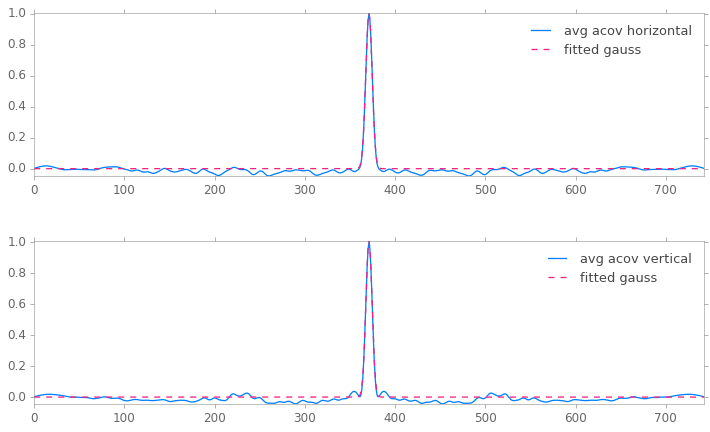


Speckle size estimates:
----------------------
FWHM: Wx = 8.4090 pixles (0.3287 mm), Wy = 8.1202 pixles (0.3173 mm)
1/e²: Wx = 14.2652 pixles (0.5576 mm), Wy = 13.7378 pixles (0.5368 mm)
Theoretical speckle width = 0.26600 mm (5.000E+02 μm)


In [27]:
estimate_mean_speckle_size(speckle, mmPerPxY, mmPerPxX) 
#print(np.mean(speckle), np.std(speckle))
print(u'Theoretical speckle width = {:.5f} mm ({:.3E} \u03BCm)'
      .format(theorySpeckleWidth, theorySpeckleWidth/wavelength))

In [28]:
ln.close()